<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/Grad-CAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [2]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/lastoct'  # data เราอยู่โฟล์เดอร์ไหน

In [6]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [7]:
# Train
train_dir = "/content/drive/My Drive/lastoct/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17779 images belonging to 4 classes.


In [8]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4552 4469 4385 4373]


In [9]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [10]:
# Validation
val_dir ="/content/drive/My Drive/lastoct/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2217 images belonging to 4 classes.


In [11]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[528 546 540 603]


## Test

In [12]:
# Test
test_dir ="/content/drive/My Drive/lastoct/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [13]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [14]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [15]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

##### ดู kernel

In [16]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [17]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.9  0.36 0.01]
 [0.55 0.68 0.37]
 [0.17 0.88 0.4 ]]


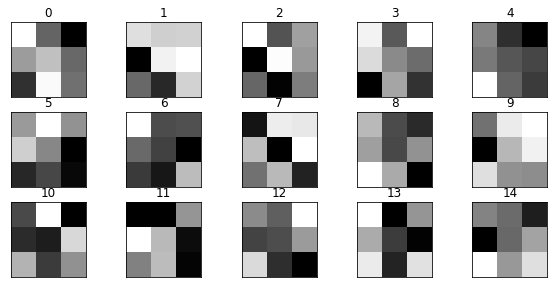

In [18]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

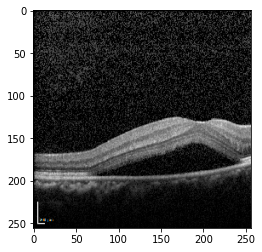

In [19]:
image = load_img('/content/drive/My Drive/lastoct/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [20]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 255.0


### Compile และ Train

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
556/556 [==============================] - 3519s 6s/step - loss: 0.9140 - accuracy: 0.6164 - val_loss: 0.9628 - val_accuracy: 0.6310
Epoch 2/10
556/556 [==============================] - 171s 308ms/step - loss: 0.3907 - accuracy: 0.8563 - val_loss: 1.1480 - val_accuracy: 0.6604
Epoch 3/10
556/556 [==============================] - 173s 310ms/step - loss: 0.1905 - accuracy: 0.9339 - val_loss: 1.2934 - val_accuracy: 0.6739
Epoch 4/10
556/556 [==============================] - 173s 310ms/step - loss: 0.0924 - accuracy: 0.9696 - val_loss: 1.6641 - val_accuracy: 0.6793
Epoch 5/10
556/556 [==============================] - 171s 307ms/step - loss: 0.0612 - accuracy: 0.9795 - val_loss: 1.6152 - val_accuracy: 0.6897
Epoch 6/10
556/556 [==============================] - 169s 305ms/step - loss: 0.0431 - accuracy: 0.9853 - val_loss: 1.9763 - val_accuracy: 0.6797
Epoch 7/10
556/556 [==============================] - 168s 302ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 1.8349 - v

### Save Model

In [23]:
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='modelOCT.h5'
model.save(filepath)
filepath_model = 'modelOCT.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [24]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## ประเมิน

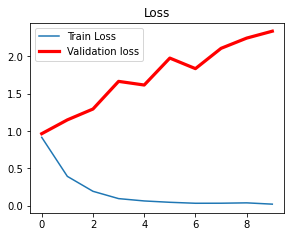

In [25]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

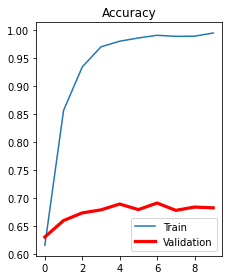

In [26]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.683


### Prediction

In [28]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image

In [29]:
train_set.class_indices

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 0s 198ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


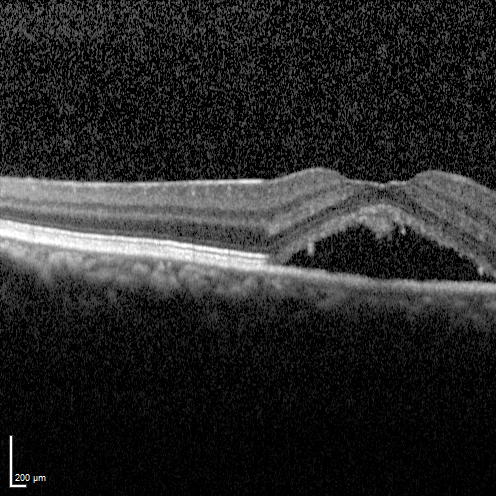

AI CSC มีความมั่นใจ 47.54%.


In [30]:
# CSC
test_path = ('/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536686, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


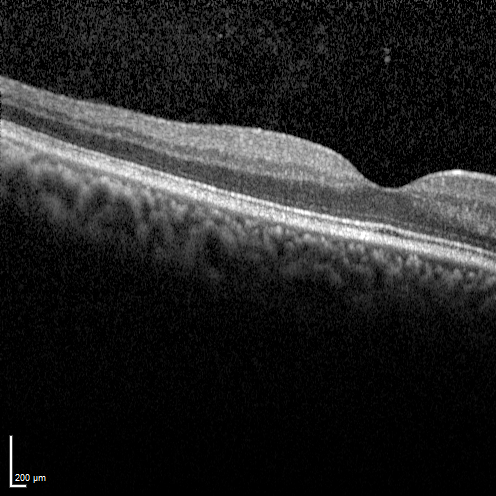

AI Normal มีความมั่นใจ 47.54%.


In [31]:
# Normal
test_path = ('/content/drive/My Drive/lastoct/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.47536686, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


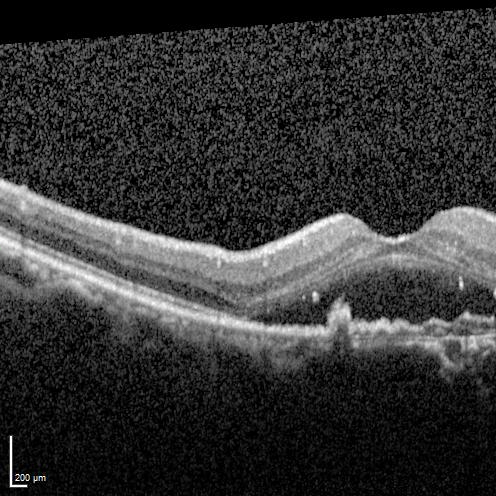

AI PCV มีความมั่นใจ 47.54%.


In [32]:
# PCV
test_path = ('/content/drive/My Drive/lastoct/test/PCV/AV0940 20-09-16 RE_001003_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


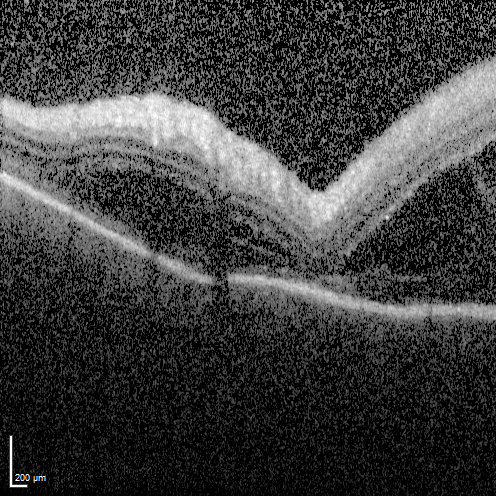

AI VKH มีความมั่นใจ 47.54%.


In [33]:
# VKH
test_path = ('/content/drive/My Drive/lastoct/test/VKH/KH7322 18-12-20 LE_001004_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [34]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 18ms/step


In [35]:
print(y_test)
print(len(y_test))

['VKH', 'CSC', 'Normal', 'PCV', 'PCV', 'VKH', 'PCV', 'CSC', 'PCV', 'Normal', 'Normal', 'VKH', 'VKH', 'VKH', 'VKH', 'PCV', 'VKH', 'VKH', 'Normal', 'Normal', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'Normal', 'VKH', 'Normal', 'CSC', 'PCV', 'PCV', 'CSC', 'CSC', 'Normal', 'PCV', 'Normal', 'CSC', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'Normal', 'Normal', 'CSC', 'PCV', 'PCV', 'VKH', 'Normal', 'Normal', 'VKH', 'Normal', 'CSC', 'Normal', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'CSC', 'PCV', 'CSC', 'Normal', 'PCV', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'Normal', 'VKH', 'PCV', 'PCV', 'Normal', 'CSC', 'VKH', 'Normal', 'CSC', 'Normal', 'Normal', 'CSC', 'Normal', 'Normal', 'Normal', 'PCV', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'VKH', 'Normal', 'PCV', 'VKH', 'Normal', 'Normal', 'PCV', 'VKH', 'Normal', 'PCV', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'VKH', 'VKH', 'VKH', 'Normal', 'Normal', 'CSC', 'VKH', 'PCV', 'Normal', 'PCV', 'CSC', 'CSC', 'PCV', 'VKH', 'PCV', 'PCV', 'CSC', 'CSC', 'Normal', 'Norma

In [36]:
print(y_pred)
print(len(y_pred))

['VKH', 'CSC', 'Normal', 'Normal', 'PCV', 'VKH', 'PCV', 'PCV', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'VKH', 'CSC', 'PCV', 'VKH', 'VKH', 'Normal', 'Normal', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'VKH', 'Normal', 'CSC', 'PCV', 'Normal', 'CSC', 'VKH', 'Normal', 'PCV', 'Normal', 'PCV', 'PCV', 'Normal', 'VKH', 'CSC', 'CSC', 'Normal', 'VKH', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'Normal', 'VKH', 'Normal', 'CSC', 'Normal', 'CSC', 'Normal', 'PCV', 'CSC', 'CSC', 'PCV', 'Normal', 'CSC', 'CSC', 'PCV', 'VKH', 'VKH', 'CSC', 'PCV', 'Normal', 'Normal', 'VKH', 'PCV', 'VKH', 'Normal', 'PCV', 'VKH', 'Normal', 'PCV', 'Normal', 'Normal', 'CSC', 'Normal', 'Normal', 'Normal', 'PCV', 'VKH', 'Normal', 'PCV', 'PCV', 'Normal', 'VKH', 'Normal', 'PCV', 'VKH', 'Normal', 'CSC', 'PCV', 'VKH', 'Normal', 'PCV', 'Normal', 'Normal', 'VKH', 'CSC', 'CSC', 'PCV', 'Normal', 'VKH', 'VKH', 'VKH', 'Normal', 'Normal', 'PCV', 'VKH', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'PCV', 'VKH', 'Normal', 'PCV', 'Normal', 'CSC'

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
confusion_matrix(y_test, y_pred)

array([[361,  71,  45,  75],
       [ 48, 488,  25,   9],
       [ 49, 109, 304,  66],
       [ 44,  23,  40, 425]])

In [39]:
cm = confusion_matrix(y_test, y_pred)

In [40]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [41]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [42]:
cm_df

,CSC,Normal,PCV,VKH
CSC,361,71,45,75
Normal,48,488,25,9
PCV,49,109,304,66
VKH,44,23,40,425


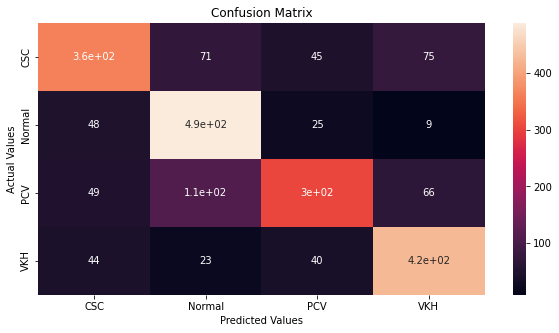

In [43]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [44]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  604


In [45]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 27.68%


In [46]:
# กำหนด path ของโฟลเดอร์ที่มีไฟล์ภาพ
folder_path = '/content/drive/My Drive/lastoct/test/'

# ดึงรายชื่อไฟล์ภาพทั้งหมดในโฟลเดอร์
image_files = os.listdir(folder_path)

# สร้าง X_test เป็น numpy array ที่มี shape (จำนวนภาพ, ความสูง, ความกว้าง, จำนวนช่องสี)
X_test = np.zeros((len(image_files), 256, 256, 3))

# วนลูปเพื่อโหลดและแปลงรูปภาพในแต่ละไฟล์เป็น numpy array
for i, file_name in enumerate(image_files):
    # โหลดรูปภาพเป็น numpy array
    img = cv2.imread(os.path.join(folder_path, file_name))


    # นำ numpy array ของรูปภาพมาเก็บไว้ใน X_test
    X_test[i] = img


In [47]:
# ดึงรูปภาพที่ทำนายผิดจากชุดข้อมูล test
# ค้นหาตัวอย่างที่มีการทำนายผิดพลาดโดยพิจารณาจากค่าที่ทำนายได้และค่าจริงของแต่ละภาพ
misclassified_indices = np.where((y_test != y_pred) & (cm > 0))[0]

# ดึงรูปภาพจากชุดข้อมูลที่ทำนายผิดครั้งแรก
idx = misclassified_indices[0]  

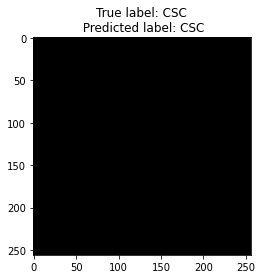

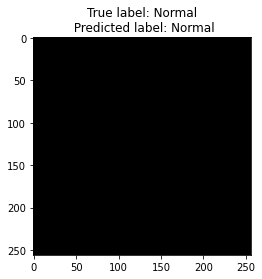

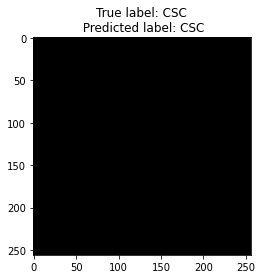

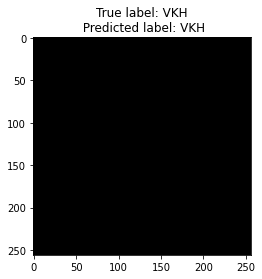

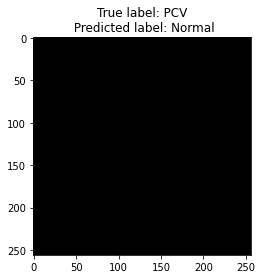

In [48]:
# หากต้องการแสดงทั้งหมดสามารถใช้คำสั่ง for loop แล้วแสดงภาพแต่ละภาพด้วย plt.imshow
for idx in np.random.choice(misclassified_indices, size=5, replace=False):
    img = X_test[idx]
    plt.imshow(img)
    plt.title(f"True label: {y_test[idx]}\n Predicted label: {y_pred[idx]}")
    plt.show()

### หาค่า Accuracy,Recall, Precision, F1-score

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [50]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.723190


In [51]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.723190


In [52]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.724304


In [53]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.718873


## Grad-CAM

In [54]:
# สร้างฟังก์ชัน generate_grad_cam สำหรับ 4 คลาส

def generate_grad_cam(model, img_tensor, layer_name, class_idx):
    # Define the gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Compute the gradient of the class output value with respect to the feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)

    # Compute the channel importance weights using global average pooling
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)

    # Compute the weighted sum of the feature map along the channel dimension
    saliency_map = np.zeros((conv_output.shape[1], conv_output.shape[2]), dtype=np.float32)

    for c in range(weights.shape[3]):
        class_map = np.zeros((conv_output.shape[1], conv_output.shape[2]), dtype=np.float32)
        for k in range(weights.shape[2]):
            alpha_c_k = weights[0, :, :, k, c]  # Weight for channel k in class c
            class_map += alpha_c_k * conv_output[0, :, :, k]
        saliency_map += class_map

    # Resize the saliency map to the size of the input image
    saliency_map = cv2.resize(saliency_map, (img_tensor.shape[2], img_tensor.shape[1]))

    # Normalize the saliency map between 0 and 1
    saliency_min = np.min(saliency_map)
    saliency_max = np.max(saliency_map)
    saliency_map = (saliency_map - saliency_min) / (saliency_max - saliency_min)

    return saliency_map

In [55]:
# สร้างคลาส GradCAM4 ที่ใช้ฟังก์ชั่น generate_grad_cam

class GradCAM4:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model(
            [self.model.inputs], [self.model.get_layer(self.layer_name).output, self.model.output]
        )

    def generate_heatmap(self, img_tensor, class_idx):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.grad_model(img_tensor)
            loss = predictions[:, class_idx]
        grads = tape.gradient(loss, conv_output)

        weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)

        saliency_map = np.zeros((conv_output.shape[1], conv_output.shape[2]), dtype=np.float32)

        for c in range(weights.shape[3]):
            class_map = np.zeros((conv_output.shape[1], conv_output.shape[2]), dtype=np.float32)
            for k in range(weights.shape[2]):
                alpha_c_k = weights[0, :, :, k, c]  # Weight for channel k in class c
                class_map += alpha_c_k * conv_output[0, :, :, k]
            saliency_map += class_map

        saliency_map = cv2.resize(saliency_map, (img_tensor.shape[2], img_tensor.shape[1]))
        saliency_min = np.min(saliency_map)
        saliency_max = np.max(saliency_map)
        saliency_map = (saliency_map - saliency_min) / (saliency_max - saliency_min)

        return saliency_map

    def overlay_heatmap(self, img_tensor, heatmap):
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap[np.where(heatmap < 0.2 * heatmap.max())] = 0
        img = img_tensor[0].numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2RGB)
        overlayed_img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

        return overlayed_img

In [56]:
# เมื่อได้ heatmap ของแต่ละภาพแล้ว ใช้ overlay_heatmap เพื่อทำการนำ heatmap มาทับกับภาพ เพื่อให้เห็นว่าโมเดลเราให้ความสำคัญกับพื้นที่ใด 

def plot_heatmap(model, img_tensor, class_idx, preprocess_input, deprocess_input):
    grad_cam = GradCAM4(model, layer_name='mixed10')
    preprocessed_img = preprocess_input(img_tensor)
    saliency_map = grad_cam.generate_heatmap(preprocessed_img, class_idx)
    overlayed_img = grad_cam.overlay_heatmap(preprocessed_img, saliency_map)
    deprocessed_img = deprocess_input(img_tensor)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    axs[0].imshow(deprocessed_img[0])
    axs[0].set_title('Input Image')
    axs[1].imshow(saliency_map, cmap='jet')
    axs[1].set_title('Heatmap')
    axs[2].imshow(overlayed_img)
    axs[2].set_title('Overlayed Image')
    plt.show()

In [57]:
img_dir = '/content/drive/My Drive/lastoct/test'

img_paths = []
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith('.png'):
            img_paths.append(os.path.join(root, file))
            
print(f'Found {len(img_paths)} images')

Found 2182 images


In [58]:
# โหลดภาพที่ต้องการสร้าง Grad-CAM
imgs_array = []
for path in img_paths:
    img = load_img(path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    imgs_array.append(img_array)

In [59]:
# ทำการสร้างโมเดลปัญญาประดิษฐ์และโหลดน้ำหนัก
model = tf.keras.models.load_model('modelOCT.h5')

In [64]:
# กำหนดชื่อเลเยอร์สุดท้ายเป็น Conv2D(64, (3,3), activation='relu') สุดท้าย
last_conv_layer = model.get_layer('conv2d_2')
x = last_conv_layer.output

In [65]:
# สร้าง Grad-CAM สำหรับแต่ละภาพ
grads_array = []
for img_tensor in imgs_array:
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('last_conv_layer').output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_output)[0]
    grads_array.append(grads)

# ทำการคำนวณน้ำหนักเฉลี่ยของเชิงพื้นที่สำหรับแต่ละภาพ
weights_array = []
for grads in grads_array:
    weights = np.mean(grads, axis=(0, 1))
    weights_array.append(weights)

# ทำการคูณและรวม activation map ด้วยน้ำหนักเฉลี่ยเพื่อสร้าง Grad-CAM สำหรับแต่ละภาพ
cams_array = []
for i, weights in enumerate(weights_array):
    conv_output = grads_array[i][0]
    cam = np.zeros(conv_output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_output[:, :, i]
    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    cams_array.append(heatmap)

# แสดงภาพและ Grad-CAM สำหรับแต่ละภาพ
for i, path in enumerate(img_paths):
    img = load_img(path, target_size=(256, 256))
    cam = cv2.resize(cams_array[i], (256, 256))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    cv2.imshow('Grad-CAM', superimposed_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

ValueError: ignored

In [ ]:
# คำนวณ gradient ของคลาสที่ทำนายผิด
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img_tensor)
    loss = predictions[:, y_pred]
    
grads = tape.gradient(loss, conv_output)[0]

# สร้าง weight สำหรับคำนวณ weighted sum ของ feature map
weights = np.mean(grads, axis=(0, 1))

# คำนวณ weighted sum ของ feature map
cam = np.dot(conv_output[0], weights)

# ทำ normalization ของ CAM
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
cam_max = cam.max()
if cam_max != 0:
    cam /= cam_max

In [ ]:
# โหลดภาพต้นฉบับ
img_orig = cv2.imread(img_path)

# สร้าง heatmap โดยวาด CAM บนภาพต้นฉบับ
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
superimposed_img = np.float32(img_orig)/255 + 0.5*heatmap
superimposed_img = superimposed_img / superimposed_img.max()

# แสดงภาพต้นฉบับและ heatmap ที่ได้
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM')
plt.show()

In [ ]:
def get_grad_cam(model, img_path, layer_name, class_index):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0

    # Expand dimension for batch
    img = np.expand_dims(img, axis=0)

    # Extract feature map
    feature_map = model.get_layer(layer_name).output
    model_new = tf.keras.models.Model(model.inputs, [feature_map, model.output])

    # Get gradient tape
    with tf.GradientTape() as tape:
        conv_output, predictions = model_new(img)
        loss = predictions[:, class_index]

    # Get gradient of loss with respect to feature map
    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    # Get weights of the last dense layer
    weights = np.mean(grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # Resize CAM to the same size as input image
    cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[2]))
    cam = np.maximum(cam, 0)

    # Normalize CAM
    cam_max = np.max(cam)
    if cam_max != 0:
        cam = cam / cam_max

    # Convert to BGR
    cam = cv2.cvtColor(cam, cv2.COLOR_GRAY2BGR)

    # Apply heatmap to original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img = cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)
    heatmap = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

    return heatmap

In [ ]:
ig, axs = plt.subplots(2, 2)

for i in range(4):
    row = i // 2
    col = i % 2

    img_path = test_set.samples[i][0]
    heatmap = get_grad_cam(model, img_path, layer_name, i)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].title.set_text('Input Image - Class ' + str(i))

    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    axs[row, col+1].imshow(heatmap)
    axs[row, col

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_grad_cam(model, img_path, layer_name, class_index):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0

    # Expand dimension for batch
    img = np.expand_dims(img, axis=0)

    # Extract feature map
    feature_map = model.get_layer(layer_name).output
    model_new = tf.keras.models.Model(model.inputs, [feature_map, model.output])

    # Get gradient tape
    with tf.GradientTape() as tape:
        conv_output, predictions = model_new(img)
        loss = predictions[:, class_index]

    # Get gradient of loss with respect to feature map
    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    # Get weights of the last dense layer
    weights = np.mean(grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # Resize CAM to the same size as input image
    cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[2]))
    cam = np.maximum(cam, 0)

    # Normalize CAM
    cam_max = np.max(cam)
    if cam_max != 0:
        cam = cam / cam_max

    # Convert to BGR
    cam = cv2.cvtColor(cam, cv2.COLOR_GRAY2BGR)

    # Apply heatmap to original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img = cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)
    heatmap = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)

    return heatmap

# Load model
model = tf.keras.models.load_model('modelOCT.h5')

# Get layer name
layer_name = 'conv5_block16_concat'

# Load test data
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='test_set',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Plot input image and Grad-CAM output for each class
fig, axs = plt.subplots(2, 2)

for i in range(4):
    row = i // 2
    col = i % 2

    img_path = test_set.samples[i][0]
    heatmap = get_grad_cam(model, img_path, layer_name, i)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].title.set_text('Input Image - Class ' + str(i))

    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    axs[row, col+1].imshow(heatmap)
    axs[row, col+1].axis('off')
    axs[row, col+1].title.set_text('Grad-CAM - Class ' + str(i))

plt.show()

In [ ]:
import numpy as np
from tensorflow import keras

# โหลดโมเดลและชุดข้อมูลทดสอบ
model = keras.models.load_model('path/to/model')
test_data = keras.preprocessing.image_dataset_from_directory('path/to/test/dataset', image_size=(256, 256), batch_size=32)

# คำนวณค่าความเป็นไปได้สำหรับการทำนายผล
y_pred_prob = model.predict(test_data)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่โมเดลทำนาย
y_pred = np.argmax(y_pred_prob, axis=1)

# หา index ของ misclassified images
misclassified_idx = np.where(y_pred != test_data.labels)[0]

In [ ]:
# 1. ทำนายผลของชุดข้อมูลทดสอบ
preds = model.predict(x_test)

# 2. หา Index ของรูปภาพที่โมเดล CNN ทำนายผิดพลาด
misclassified_idx = np.where(np.argmax(preds, axis=1) != y_test)[0]

# 3. โหลดรูปภาพที่โมเดล CNN ทำนายผิดพลาดนั้น และทำการประมวลผลด้วย Grad-CAM
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tf_keras_vis.gradcam import Gradcam

In [ ]:
# โหลดโมเดล VGG16 และทำการ preprocess รูปภาพ
model = VGG16(weights='imagenet')
img_path = 'path/to/misclassified/image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# สร้าง Grad-CAM instance ด้วยโมเดล CNN และชื่อ layer ที่ต้องการสร้าง visualization
cam = Gradcam(model, layer_name='block5_conv3')

# ทำการ generate Grad-CAM visualization
gradcam = cam.compute_heatmap(x)

# 4. แสดงรูปภาพและ visualization ของ feature map ที่ทำให้โมเดลทำนายผิดพลาดได้
import matplotlib.pyplot as plt
plt.imshow(img)
plt.imshow(gradcam, alpha=0.5, cmap='jet')
plt.show()

In [ ]:
# โหลดโมเดล VGG16 และทำการ preprocess รูปภาพ
model = VGG16(weights='imagenet')

# อ่านไฟล์ csv ที่เก็บ index ของ misclassified images
with open('misclassified_index.csv', 'r') as f:
    misclassified_index = [int(idx) for idx in f.readlines()]

# สร้าง Grad-CAM instance ด้วยโมเดล CNN และชื่อ layer ที่ต้องการสร้าง visualization
cam = Gradcam(model, layer_name='block5_conv3')

# loop เพื่อแสดงรูปภาพและ Grad-CAM visualization ของรูปภาพที่ทำนายผิดพลาด
for idx in misclassified_index:
    img_path = f'path/to/misclassified/image_{idx}.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # ทำการ generate Grad-CAM visualization
    gradcam = cam.compute_heatmap(x)

    # แสดงรูปภาพและ visualization ของ feature map ที่ทำให้โมเดลทำนายผิดพลาดได้
    plt.imshow(img)
    plt.imshow(gradcam, alpha=0.5, cmap='jet')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from gradcam import Gradcam

# Load model
model = load_model('modelOCT.h5')

# Load misclassification indices from CSV file
indices = np.loadtxt('misclassified_indices.csv', delimiter=',')

# Create Gradcam instance with model and layer name
gradcam = Gradcam(model, layer_name='conv5_block3_2_conv')

# Loop through misclassification indices and display image and Grad-CAM visualization
for index in indices:
    # Load image and preprocess
    img = load_img(f'images/{int(index)}.jpg', target_size=(256, 256))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Generate Grad-CAM visualization
    heatmap = gradcam.compute_heatmap(x)

    # Display original image and Grad-CAM visualization
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.5, cmap='jet')
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

### อ่าน index ของรูปภาพที่ทำนายผิดพลาดจากไฟล์รูปภาพ

In [ ]:
from PIL import Image

image_path = '/path/to/'

from PIL import Image
import numpy as np

image_path = '/path/to/image.png'

# โหลดรูปภาพจากไฟล์
img = Image.open(image_path)

# แปลงเป็น NumPy array
img_array = np.array(img)

# แสดงรูปภาพ
img.show()

In [67]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# โหลดโมเดล
model_path = '/path/to/modelOCT.h5'
model = load_model(model_path)

# สร้างฟังก์ชั่น Grad-CAM
def grad_cam(img_tensor, model, layer_name, img_width, img_height):
    # หาค่า output และ feature map ที่เกี่ยวข้องกับชั้น layer_name
    x = img_tensor
    for layer in model.layers:
        if layer.name == layer_name:
            x = layer.output
            break
    model_input = model.input
    output = model.output
    grads = K.gradients(output, x)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model_input], [pooled_grads, x])
    pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
    
    # คำนวณค่า weight ที่ใช้ในการหา sum ของ feature map
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    # หา sum ของ feature map
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    # ปรับขนาด heatmap เหมือนกับขนาดของ input image
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = np.resize(heatmap, (img_width, img_height))
    
    return heatmap

# กำหนดชื่อชั้นที่จะใช้ในการสร้าง Grad-CAM
layer_name = 'block5_conv3'

# แสดงรูปภาพที่ทำนายผิดพลาดพร้อมกับ index
for idx, row in df[df['prediction_correct'] == False].iterrows():
    img_path = row['image_path']
    img = Image.open(img_path)
    img

OSError: ignored